# Java 调用图生成工具的比较

这篇文章主要是为了比较，看不同调用图生成工具跑出来的调用图有哪些区别。

## 1. 引言部分

调用图 (`Call Graph`) 是一种描述过程间控制流与数据流的工具。图中节点表示方法，图中有向边连接两个节点，用于表示 **起始节点对应的方法** 调用了 **目标节点对应的方法**。

**静态图往往过分估计了调用图中边的数量**。这是因为在 OOP 语言中，一个方法的调用与 **运行时** `receiver` 的类型有关。所以，在创建静态图的时候，经常需要确定一个类型的对象可能会调用哪些方法。确定上述 **可能调用方法集合** 的算法是导致调用图产生区别的主要原因之一。

但还有许多类似影响调用图结构的要素。（文中举了个例子，比如匿名类的初始化方法选择（我不懂为什么啊））

接着，文中举出了 3 点：

1. 处理 `Java` 语言中语言特性的方式，如何影响调用图结构；
2. 实际调用图结构的差别体现在哪里；
3. 忽略某些差别，调用图结构是否相同（啥意思？）。

## 2. 相关工作

第二部分对调用图相关的文献进行了讨论。

调用图是刻画 `high level` 控制流的一种方法。不管被分析的语言是低级的二进制、汇编或是高级的 OO，调用图的构造总是一个问题。

首先是准确性，如果一个调用图把一个程序在动态执行时所有调用的方法都 “准确无误” 地指出了（包括多态也指定特定的方法），那就称之为 “准确”。然而，静态分析做不到这样准确。

对于调用对象方法的 `virtual call` 这个概念，就是无法做到 “准确” 的情形之一。针对这种问题，有两种方法，**上下文有关 / 无关分析方法的选择** 是 **影响调用图结构的因素之一**。

1. 上下文有关分析：比较准确，因为是按照顺序的。
2. 上下文无关分析：CHA / RTA / XTA / VTA 等算法被用于在 “准确性” 与 “正确性” 间做取舍。

另外一个因素是 **对库函数的处理**。

如果增加了库函数部分，那图会变得很大。但如果不加入的话，当在开发底层接口时，分析起来就没用（因为开发的就是那个玩意儿，环境就是它）。

决定 **处理库函数** 后，通常会把 `private-call / inaccessable-call` 也加入进去。通常使用的 `CHA / RTA` 算法没有考虑库函数。

文中说：

> . The tools we selected for our
comparison represent library calls and library methods at various levels of detail.

接着就是说了些其他人的研究成果。比如 C++ 的调用图构建方式；JavaScript 静态调用图创建工具；给出提升了准确性的 RTA 算法；比较了 Soot 和 \*J 构建的图，给出了比较调用图间区别的算法（Comparing call graphs. In ´ ACM SIGPLAN/SIGSOFT Workshop on Program Analysis for Software Tools and Engineering, pages 37–42）。

## 3. 调用图创建工具

第三部分比较了 6 种工具。

### 3.1 Soot

一种可以操作（比如修改）以及优化 IR 的工具。文中给的是 2019 的 Soot，支持的语言特性，然后我看了下截至目前应该也是只到支持 9。使用的是 CHA。

### 3.2 OpenStaticAnalyzer

不仅仅对 Java，还可以处理 JavaScript / Python / C#。处理了递归目录问题，在程序分析时考虑构建系统的影响。通过遍历 AST 获取 `invocation information` 来创建调用图。

### 3.3 SPOON

支持 Java 9。由于只是 Java 的，就根据已有目录分析，构建类似 AST 的模型（感觉在这里算是一种 IR）。本文说这个东西 **Well-documented**，吼！

### 3.4 Java Call Graph

据说也是 Java 8，需要输入一个 jar 文件，也就是说是用来解释 jar 的。具备探测 `dead code` 的功能，会自动去掉未被执行到的代码。

### 3.5 WALA

为了使分析结果与其他工具相似（感觉就很怪，为什么这样？），WALA 把所有的 **非私有 + 非抽象** 方法都视作可能的 **entry**。（而不是找到一个 main 方法，然后把 main 当作入口）

### 3.6 Eclipse JDT

支持到 Java 10。生成类似 AST 状的 IR。

## 4. 评估过程

第四部分给出了工具的评估标准。这篇文章重点在于比较各个静态分析工具的优劣，所以需要一个评价方法。然而，有一说一，这一段并没有在说这件事，感觉却是在做实验的预处理——处理不同工具在方法名的 `representation` 上的文本差异。

在 Java 中，方法可以被看作成一个由 **包名.类名.方法名(参数类型列表)** 组成的标签。当然，但是这只是最简单的说法，还有很多由于 Java 语法特性导致的问题没有解决，比如 **匿名类 / 方法 / lambda 表达式**。

在不同的工具中，命名系统也不尽相同。文中给出了 OSA 和 Soot 对于方法的不同命名方式，以表示这种差矣真的存在（所以原作者是在纯水字数吧？）

## 5. 调用图比较

第五部分对评估结果的量化指标进行了解释说明。作者这边是希望通过导出的调用图，分析图的差异，并将这些差异人工分类，以找到造成这些差异的因素。

### 5.1 处理 Java 特性

Java 其实语法比较简单，但由于其是教科书般的 OO，并且提供了一些语法糖，毫无疑问已经存在一些需要特殊处理的语法特性了。

#### 5.1.1 构造函数

上面总共把工具分成了两类，一类基于 AST 的调用图，一类基于字节码（说实话基于字节码是啥意思啊？）。具体细节就不说了，反正要特殊处理。

这个段落后面还说了 `static initializer`，也就是 Java 中的静态块。

#### 5.1.2 多态

多态会导致调用图的 “不准确”。原因是：静态分析器不知 “究竟就是当前这个对象，还是该对象类型的某一种子类”。于是，当一个方法被调用时，（或许是为了速度）很多分析器采取了 “保守策略”——不去找那个 “准确” 的类，而是把方法直接链到图中 “最初的父类” 上，也就是一种类型上的 `points-to analysis`，`Name Based Resolution (NBR)`。

只有 WALA 和 Soot 使用了不一样的算法，WALA 是什么 **ZeroOneContainerCFA**，没听说过，然后 Soot 用的是 CHA。

然后这段没看懂：

```english
but the implementation is incorrect in the sense that neither
WALA nor Soot realize method invocations of default
methods of interfaces. If a method is not overridden
in the derived class, JCG generates a copy of the base
method in the derived class. This method is callable
if the static type of the object at the calling site makes
it possible, however, this method does not refer to the
original method and the called methods of the original. So an application, which traverses the possible
execution paths, will miss some potential paths.
```

#### 5.1.3 匿名类 / 匿名方法

文中说，这个要素并不是造成调用图差矣的重要原因。

#### 5.1.4 泛型

Java 编译器使用 “[类型擦除](https://www.cnblogs.com/treasury/p/13229762.html)” 实现泛型，它用泛型类型中的所有类型参数替换它们的边界。如果类型参数未绑定，则用 Object 这个最基本的类型替换。类型擦除在大多数情况下由调用图工具使用。尽管 WALA 和 Soot 还使用类型擦除来指定目标方法，其定义至少包含一个泛型参数，这些工具将实际参数的类型传播到被调用的方法中。

按道理说，Java 中的泛型并非真正泛型，类型实例化泛型对象不会导致更多的代码产生。但是按照文中所述，Soot 和 WALA 都会像真泛型一样处理泛型。

#### 5.1.5 Java 8

文中被提及的 Java 8 主要特性：函数式编程能力、lambda 表达式、方法引用、

这里就说三个分析器需要关注的重点：

* 只有 WALA 能创建专用于 lambda 表达式的节点，其他工具都把 lambda 表达式当作接口的具体实现；
* WALA 也能创建特殊的 “函数式接口”；
* 上述新功能的核心是 “函数式接口”，lambda 表达式和方法引用可以用来表示 “函数式接口”。

#### 5.1.6 动态方法调用

本文说了：

```english
Since none of the tools provided a solution for the
handling of these invocations, we are not dealing with
them in the rest of the paper, similarly to native JNI
calls and callback methods.
```

### 5.2 调用图差异的量化

有一说一，这个表格太搞了。当时掏出这篇论文的时候，我和老师在不看正文的前提下猜了三分钟这些表格中的数字在表示什么。

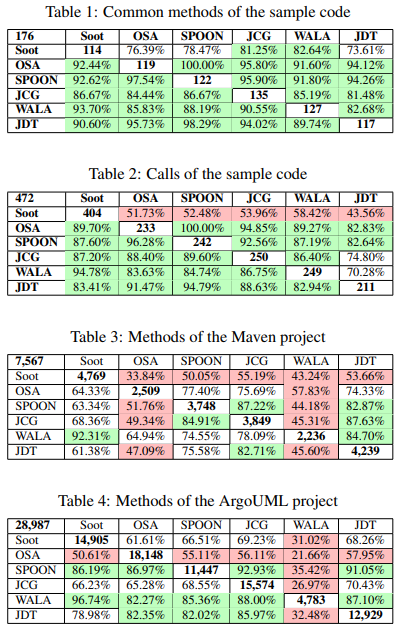

仔细看了下解释我才明白：

1. 左上角的表示总数；
2. 对角线上的数字表示该工具发现的准确数目；
3. 以对角线上某一个数字为中心，看向它的水平方向，表示：“这个数字，在那个单元格所在列对应的工具中，有多少被发现”。举个例子，OSA 发现 119 个方法，在 SPOON 中，这 119 个方法都被发现了（122 与 119 100% 重合），但在 WALA 中，却只被发现了 91.60%（127 和 122 中有 91.60% 重合）。
4. 以对角线上某一个数字为中心，它的垂直方向没有意义。

这里需要注意的是，**并不是找的东西多、数字大就是好**。方法数量多可能是因为 “静态块” 以及其他一些或许无关紧要的 element 被当成了节点，也有可能是没办法找出太多的 `dead code`；同理，边数量多可能是算法并不完美，不能精确地确定可被执行的方法。

### 5.3 存在差异的原因

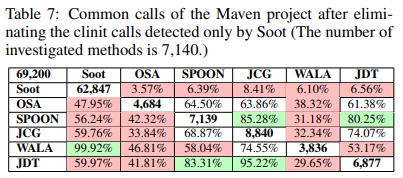

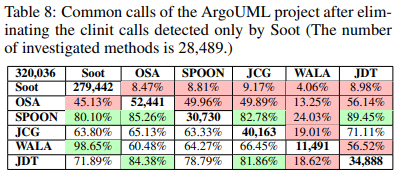

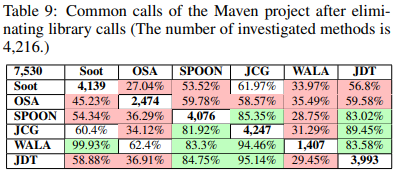

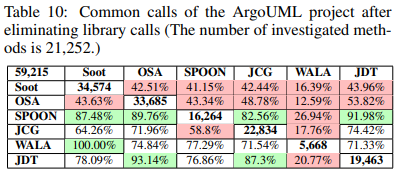

首先是对语言 element 处理的不同。比如 “静态块”，有的把它看成一个节点，有的就不这么看；其次是库的调用，Soot 提供了非常详尽的库调用节点，但是这可能并不重要？

所以可以尝试把所有工具探测到的节点和边聚在一起：

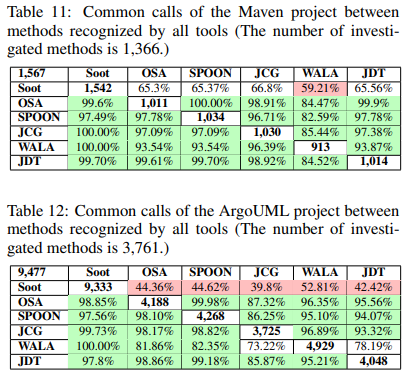

可以看出 WALA 是最少的。但是问题在于如果我们看 $\dfrac{| \bigcap_{six\ analyzers} CommonCall |}{CommonCalls_i}$ 时，WALA 的比例是最高的。说明 WALA 更能产生被六个解析器都认可的边。虽然说这个比率高也只能高到 23%。

WALA 可能忽略了很多其他解析器纳入考虑范围内的节点。WALA 的可达性算法做得更好，很有可能只会生成可达的方法节点和调用边。

最后这个文章得出了一句在我看来的废话：

```english
As we have seen, there were so many minor differences
between the graphs we did not think of as a lay user.
```

我就觉得搞笑，这肯定不一样吧，为啥你觉得不同的解析器实现会生成相同结果啊？这篇不会本来是想搞个大新闻吧？

## 6. 数据有效性的可能影响因素

第六部分给出了可能影响结果的几个因素。但我想我暂时不会看这个。

## Note

| English | Chinese |
|:-:|:-:|
| imprecisions | 不确定性 |
| extensive literature | 大量文献 |
| mitigate | 减轻 |
| nomenclature | 命名法 |
| solely | 仅仅 |
| cumbersome | 笨重繁琐的 |
| discrepancy | 差异 |